In [1]:
%matplotlib inline
# %%capture
# python libraties
import os, itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from glob import glob
from PIL import Image
import cv2
import time
import copy
# pytorch libraries
import torch
import torch.nn.functional as F
from torch import optim,nn
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset
from torchvision import models, transforms, utils
from torchsummary import summary
from torchsampler import ImbalancedDatasetSampler
# from imblearn.over_sampling import SMOTE
# sklearn libraries4
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
import math
# import gc

In [2]:
# data directory 
data_dir = 'data'   

In [3]:
def set_parameter_requires_grad(model, child_no = 8, finetuning = False):
    '''
        This function freezes the parameters of the model.
        
        Parameters:
            model: model to be freezed before training
            child_no the layer to be reamined unfreezed for training
            finetuning: if finetuning is true then the model will not be freezed
        
        Returns:
            Nothing
    '''
    if not finetuning:
        print(finetuning)
        for param in model.parameters():
            param.requires_grad = False
    else: 
        print(finetuning)
        child_counter = 0
        for child in model.children():
            if child_counter == child_no:
                print("child ",child_counter," was frozen")
                for param in child.parameters():
                    param.requires_grad = False
            else:
                print("child ", child_counter," is not frozen")
                for param in child.parameters():
                    param.requires_grad = True
            child_counter += 1
            
        

In [21]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
      
class ClassifierNew(nn.Module):
    def __init__(self, inp = 2208, h1=1024, out = 7, d=0.35):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d((1,1))
        self.mp = nn.AdaptiveMaxPool2d((1,1))
        self.fla = Flatten()
        self.bn0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(d)
        self.fc1 = nn.Linear(inp*2, h1)
        self.bn1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(d)
        self.fc2 = nn.Linear(h1, out)
        
    def forward(self, x):
        ap = self.ap(x)
        mp = self.mp(x)
        x = torch.cat((ap,mp),dim=1)
        x = self.fla(x)
        x = self.bn0(x)
        x = self.dropout0(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)         
        x = self.fc2(x)
        
        return x

In [22]:
def initialize_models(model_name, num_classes = 7, fine_tuning = False):
    '''
        This function initialize3s the pretrained model
    '''
    
    model_fe = None
    input_size = 0
    
    if(model_name == 'resnet'):
        model_fe = models.resnet101(pretrained = True)
        set_parameter_requires_grad(model_fe, fine_tuning)
        num_ftrs = model_fe.fc.in_features
        model_fe = torch.nn.Sequential(*(list(model_fe.children())[:-2]))
        model_fe.fc = ClassifierNew(inp = num_ftrs, out = num_classes, d = 0.1)
#         model_fe.fc = nn.Linear(num_ftrs, num_classes)
        input_size = (224, 224)
    
    elif(model_name == 'densenet'):
        model_fe = models.densenet201(pretrained = True)
        set_parameter_requires_grad(model_fe, fine_tuning)
        num_ftrs = model_fe.classifier.in_features
        model_fe.classifier = ClassifierNew(inp = num_ftrs, out = num_classes)
#         model_fe.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = (224, 224)
        
    elif(model_name == 'inception'):
        model_fe = models.inception_v3(pretrained = True)
        model_fe.aux_logits = False
        set_parameter_requires_grad(model_fe, fine_tuning)
        num_ftrs = model_fe.fc.in_features
        model_fe.fc = ClassifierNew(inp = num_ftrs, out = num_classes)
        input_size = (299, 299)
    
    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]
    return model_fe, input_size, norm_mean, norm_std
        

## Training Script

In [6]:
def train_model(model, criterion, optimizer, dataloader, scheduler = None, num_epochs=25):
    since = time.time()
    
    val_acc, val_loss = [],[]
    train_acc, train_loss = [],[]
    lr_rate = []
    
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
#                 print('phase train')
#                 for param_group in optimizer.param_groups:
#                     print('Learning Rate {}'.format(param_group['lr']))
#                     lr_rate.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
#                 print('phase val')
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if phase == 'train' and scheduler is not None:
                    scheduler.step()
                    lr_rate.append(scheduler.get_lr()[0])
                
            del inputs
            del labels
            torch.cuda.empty_cache()
                
            

            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloader[phase].dataset)
            
            if phase == 'train':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
            else:
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 print('Best accuracy {}'.format(best_acc))
#                 best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
#     model.load_state_dict(best_model_wts)
    return model, val_loss, val_acc, train_loss, train_acc, lr_rate

## class weights for the sampler

In [7]:
import pandas as pd
from collections import Counter
from collections import OrderedDict 

def get_class_weights(y, forsampler = True):
    counter = Counter(y)
    dic = {}
    if not forsampler:
        majority = max(counter.values())
        dic = {cls: float(majority)/count for cls, count in counter.items()}
    else:
        dic = {cls: 1 / count for cls , count in counter.items()}
    
    dic = OrderedDict(sorted(dic.items()))
    weights = list(dic.values())
    sample_weights = [weights[t] for t in y]
    sample_weights = torch.FloatTensor(sample_weights)

    return sample_weights

## data transforms

In [8]:
# transfromations for train images
def get_transforms(input_size, norm_mean, norm_std):
    train_transform = transforms.Compose([transforms.Resize(input_size),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.ToTensor(), 
                                          transforms.Normalize(norm_mean, norm_std)])
    # define the transformation of the test images.
    test_transform = transforms.Compose([transforms.Resize(input_size), 
                                        transforms.ToTensor(),
                                        transforms.Normalize(norm_mean, norm_std)])
    
    return train_transform, test_transform

In [9]:
# del model
torch.cuda.empty_cache()

## Custom Dataset

In [10]:
class HamDataset(Dataset):
    def __init__(self, csvpath, transform = None):
        self.df = pd.read_csv(csvpath)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))
        
        if self.transform:
            X = self.transform(X)
        
        return X, y

## Dataloader Function

In [11]:
def get_data_loader(csvpathh, transform, batch_size = 7):
    csvpath = os.path.join(data_dir, csvpathh)
    df = pd.read_csv(csvpath)
    dataset = HamDataset(csvpath, transform)
    sampler = None
    if(csvpathh == 'train.csv'):
        print(csvpath)
        class_weights = get_class_weights(df.cell_type_idx.values, forsampler = True)
        sampler = torch.utils.data.sampler.WeightedRandomSampler(class_weights, len(class_weights))
        dataloader = DataLoader(dataset, batch_size=batch_size, sampler = sampler, num_workers=0)
    else:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle = True, num_workers=0)        
    return dataloader

In [12]:
def imshow(inp, mean, std, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    plt.figure(figsize=(200,100))
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated
    plt.savefig('graphs/processedimages.png')

In [122]:
# from torchvision.models.densenet import DenseNet
# class myDenseNet(DenseNet):
#     def __init__(self, inp = 1920, out = 7):
        
#         super(myDenseNet, self).__init__(32, (6, 12, 48, 32), 64)
#         self.classifier = ClassifierNew(inp = inp, out = out)
    
#     def forward(self, x):  
#         features = self.features(x)
#         x = F.relu(features, inplace=True)
#         x = F.relu(features, inplace=True)
#         x1 = F.adaptive_avg_pool2d(x, (1, 1))
#         y = F.adaptive_max_pool2d(x, (1,1))
#         self.classifier(x)
#         return x
    
# model = myDenseNet()
# # if you need pretrained weights
# p = models.densenet201(pretrained=True).state_dict()   

In [13]:
# model.load_state_dict(p)
# model = model.to(device)

In [14]:
# model.classifier = ClassifierNew(inp = 1920, out = 7)

In [15]:
# model

In [16]:
# summary(model, (3, 224, 224))

## model and data declaration

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model, input_size, norm_mean, norm_std = initialize_models('resnet', num_classes = 7)
model = model.to(device)
# input_size = (224, 224)
# norm_mean = [0.485, 0.456, 0.406]
# norm_std = [0.229, 0.224, 0.225]

train_transform, test_transform = get_transforms(input_size, norm_mean, norm_std)

dataloader = {'train': get_data_loader('train.csv', transform = train_transform, batch_size = 32),
           'val': get_data_loader('validation.csv',  transform = train_transform, batch_size = 32),
             'test': get_data_loader('test.csv', transform = train_transform, batch_size = 32)}

False
data\train.csv


In [29]:
summary(model, input_size = (3, 224, 224))
# model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

(tensor(46712903), tensor(4212743))

<class 'torch.Tensor'>
torch.Size([32, 3, 224, 224])
torch.Size([32])


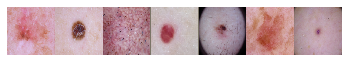

<Figure size 14400x7200 with 0 Axes>

In [30]:
inputs, classes = next(iter(dataloader['train']))

# Make a grid from batch
inputs = inputs[:7]
classes = classes[:7]
out = utils.make_grid(inputs)

imshow(out, norm_mean, norm_std, title=classes)
classes
dataiter = iter(dataloader['train'])
images,labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

## Lr finder

In [21]:
def lr_finder(model, dataloader, criterion, optmizer, lr_find_epochs = 5, start_lr = 1e-7, end_lr = 0.1):

    lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len( dataloader["train"])))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    lr_find_loss = []
    lr_find_lr = []

    iter = 0

    smoothing = 0.05

    for i in range(lr_find_epochs):
      print("epoch {}".format(i))
      for inputs, labels in tqdm(dataloader["train"]):

        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Training mode and zero gradients
        model.train()
        optimizer.zero_grad()

        # Get outputs to calc loss
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update LR
        scheduler.step()
        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        # smooth the loss
        if iter==0:
          lr_find_loss.append(loss)
        else:
          loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
          lr_find_loss.append(loss)

        iter += 1
    
    max_lr = lr_find_lr[lr_find_loss.index(min(lr_find_loss))] / 10
    base_lr = max_lr / 6
    return lr_find_loss, lr_find_lr, max_lr, base_lr


In [48]:
start_lr = 1e-7
criterion = nn.CrossEntropyLoss().to(device)  
optimizer = optim.Adam(model.parameters(), lr=start_lr)
loss, lr, max_lr, base_lr = lr_finder(model, dataloader, criterion, optimizer, start_lr = start_lr)

In [20]:
print(max_lr)
print(base_lr)
min(loss)
# len(lr)

6.827877398078823e-05
1.1379795663464706e-05


tensor(0.7610, device='cuda:0', grad_fn=<AddBackward0>)

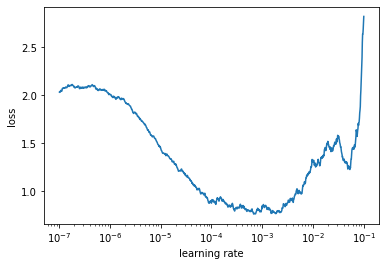

In [21]:
plt.ylabel("loss")
plt.xlabel("learning rate")
plt.xscale("log")
plt.plot(lr, loss)
plt.savefig('graphs/resnet101-adam-2/lr-loss.png')
plt.show()

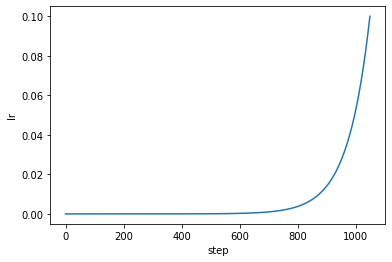

In [22]:
plt.ylabel("lr")
plt.xlabel("step")
plt.plot(range(len(lr)), lr)
# plt.savefig('graphs/resnet101-adam-2/lr-growth.png')
plt.show()

## Training 

In [31]:
criterion = nn.CrossEntropyLoss().to(device)  
optimizer = optim.Adam(model.parameters(), lr = 8.33e-5)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, mode = 'triangular2')
model, val_loss, val_acc, train_loss, train_acc, lr_rate = train_model(model, criterion, optimizer, dataloader, num_epochs = 30)

Epoch 0/29
----------



train Loss: 0.9321 Acc: 0.6675



val Loss: 0.5663 Acc: 0.8150

Epoch 1/29
----------



train Loss: 0.6270 Acc: 0.7814



val Loss: 0.5499 Acc: 0.8150

Epoch 2/29
----------



train Loss: 0.5459 Acc: 0.8152



val Loss: 0.5128 Acc: 0.8233

Epoch 3/29
----------



train Loss: 0.4685 Acc: 0.8463



val Loss: 0.4270 Acc: 0.8581

Epoch 4/29
----------



train Loss: 0.4262 Acc: 0.8558



val Loss: 0.4474 Acc: 0.8562

Epoch 5/29
----------



train Loss: 0.3919 Acc: 0.8682



val Loss: 0.4317 Acc: 0.8681

Epoch 6/29
----------



train Loss: 0.3434 Acc: 0.8894



val Loss: 0.4887 Acc: 0.8416

Epoch 7/29
----------



train Loss: 0.3313 Acc: 0.8865



val Loss: 0.4705 Acc: 0.8663

Epoch 8/29
----------



train Loss: 0.3123 Acc: 0.8971



val Loss: 0.4100 Acc: 0.8700

Epoch 9/29
----------



train Loss: 0.2948 Acc: 0.9031



val Loss: 0.4577 Acc: 0.8553

Epoch 10/29
----------



train Loss: 0.2755 Acc: 0.9077



val Loss: 0.5059 Acc: 0.8571

Epoch 11/29
----------



train Loss: 0.2678 Acc: 0.9126



val Loss: 0.4363 Acc: 0.8681

Epoch 12/29
----------



train Loss: 0.2505 Acc: 0.9189



val Loss: 0.4760 Acc: 0.8672

Epoch 13/29
----------



train Loss: 0.2442 Acc: 0.9183



val Loss: 0.4590 Acc: 0.8526

Epoch 14/29
----------



train Loss: 0.2163 Acc: 0.9254



val Loss: 0.4545 Acc: 0.8626

Epoch 15/29
----------



train Loss: 0.2142 Acc: 0.9299



val Loss: 0.4317 Acc: 0.8672

Epoch 16/29
----------



train Loss: 0.2175 Acc: 0.9265



val Loss: 0.4154 Acc: 0.8791

Epoch 17/29
----------



train Loss: 0.1961 Acc: 0.9359



val Loss: 0.4212 Acc: 0.8681

Epoch 18/29
----------



train Loss: 0.1817 Acc: 0.9398



val Loss: 0.4322 Acc: 0.8663

Epoch 19/29
----------



train Loss: 0.1822 Acc: 0.9433



val Loss: 0.4490 Acc: 0.8599

Epoch 20/29
----------



train Loss: 0.1907 Acc: 0.9366



val Loss: 0.4476 Acc: 0.8599

Epoch 21/29
----------



train Loss: 0.1819 Acc: 0.9409



val Loss: 0.5036 Acc: 0.8452

Epoch 22/29
----------



train Loss: 0.1665 Acc: 0.9456



val Loss: 0.3945 Acc: 0.8874

Epoch 23/29
----------



train Loss: 0.1636 Acc: 0.9462



val Loss: 0.4080 Acc: 0.8810

Epoch 24/29
----------



train Loss: 0.1477 Acc: 0.9524



val Loss: 0.4520 Acc: 0.8718

Epoch 25/29
----------



train Loss: 0.1609 Acc: 0.9469



val Loss: 0.4401 Acc: 0.8663

Epoch 26/29
----------



train Loss: 0.1536 Acc: 0.9490



val Loss: 0.4458 Acc: 0.8727

Epoch 27/29
----------



train Loss: 0.1480 Acc: 0.9529



val Loss: 0.4969 Acc: 0.8645

Epoch 28/29
----------



train Loss: 0.1518 Acc: 0.9492



val Loss: 0.3987 Acc: 0.8864

Epoch 29/29
----------



train Loss: 0.1424 Acc: 0.9526



val Loss: 0.4723 Acc: 0.8645

Training complete in 169m 28s


In [32]:
dirr = "D:\Github\SkinCancerCapstone\models"
torch.save(model, os.path.join(dirr, 'resnet101-adam-2.pth'))

C:\ProgramData\Anaconda3\envs\pythongpu\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ClassifierNew. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\envs\pythongpu\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [140]:
# plt.ylabel('Learning rate')
# plt.xlabel('Steps')
# plt.title('Learning Rate over Steps') 
# plt.plot(lr_rate, label = 'learning rate')
# plt.grid()
# plt.savefig('graphs/resnet101-adam/lr.png')
# plt.legend()
# plt.show()
# val_loss

In [141]:
lr_rate

[]

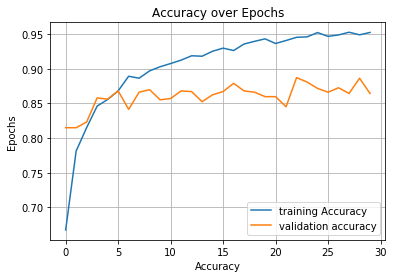

In [33]:
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.title('Accuracy over Epochs') 
plt.plot(val_acc, label = 'training Accuracy')
plt.plot(train_acc, label = 'validation accuracy')
plt.grid()
plt.savefig('graphs/resnet101-adam-2/accuracy.png')
plt.legend()
plt.show()

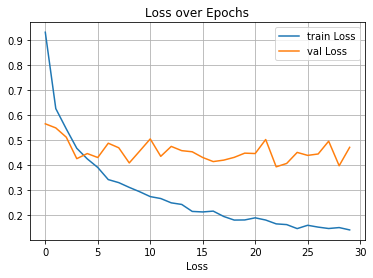

In [34]:
plt.xlabel('Loss')
plt.title('Loss over Epochs')
plt.plot(val_loss, label = 'train Loss')
plt.plot(train_loss, label = 'val Loss')
plt.grid()
plt.savefig('graphs/resnet101-adam-2/loss.png')
plt.legend()
plt.show()

In [45]:
def plot_confusion_matrix(matrix, labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(matrix)

    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels) #, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('graphs/resnet101-adam/conf_mat-tta.png')
    plt.show()
    

In [43]:
model = torch.load("D:/Github/SkinCancerCapstone/models/resnet101-adam.pth")
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for images, labels in tqdm(dataloader['test']):
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

conf_matrix = confusion_matrix(y_true=y_label, y_pred=y_predict)
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'mel','vasc']

Normalized confusion matrix


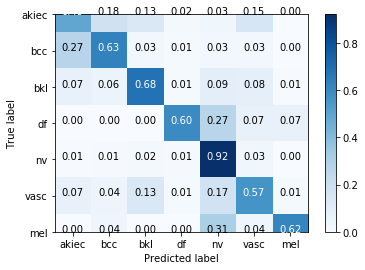

0.6435196540290001


In [46]:
plot_confusion_matrix(conf_matrix, labels=plot_labels, normalize=True)
print(balanced_accuracy_score(y_label, y_predict))


In [47]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.38      0.49      0.43        61
         bcc       0.51      0.63      0.56        70
         bkl       0.69      0.68      0.69       177
          df       0.33      0.60      0.43        15
          nv       0.97      0.92      0.95      1776
        vasc       0.37      0.57      0.44        92
         mel       0.64      0.62      0.63        26

    accuracy                           0.86      2217
   macro avg       0.56      0.64      0.59      2217
weighted avg       0.88      0.86      0.87      2217



## Predict Function

In [75]:
from PIL import Image

def predict(path, modelpath = "D:/Github/SkinCancerCapstone/models/resnet101-classifier.pth"):
    model = torch.load(modelpath)
    model.eval()
    
    img = Image.open(path)
    img = test_transform(img).float()
    img = Variable(img, requires_grad=False)
    img = img.unsqueeze(0).cuda()
    output = model(img)
    print(output)
    m = nn.Softmax(dim = 1)
    op = m(output).tolist()
    print(op)
    prediction = output.max(1, keepdim=True)[1].tolist()
    prediction = prediction[0][0]
    print(prediction, op[0][prediction])

In [80]:
predict("D:/Github/SkinCancerCapstone/report/img/melanoma.jpg")

tensor([[-0.8541, -7.2931,  2.5407, -6.8576,  5.4922,  6.1139, -0.3118]],
       device='cuda:0', grad_fn=<AddmmBackward>)
[[0.0006006199982948601, 9.597472399036633e-07, 0.01790272630751133, 1.4835470665275352e-06, 0.3425754904747009, 0.6378856301307678, 0.00103298993781209]]
5 0.6378856301307678
